In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
image_size = 28

class ShapesDataset(Dataset):
    def __init__(self, num_samples, image_size=28):
        self.num_samples = num_samples
        self.image_size = image_size
        self.data, self.labels = self.generate_data(num_samples, image_size)
        
    def generate_data(self, num_samples, image_size):
        data = []
        labels = []
        for _ in range(num_samples):
            image = np.zeros((image_size, image_size), dtype=np.float32)
            # Draw a circle
            radius = np.random.randint(5, image_size // 4)
            center_x = np.random.randint(radius, image_size - radius)
            center_y = np.random.randint(radius, image_size - radius)
            y, x = np.ogrid[:image_size, :image_size]
            mask = (x - center_x)**2 + (y - center_y)**2 <= radius**2
            image[mask] = 1.0
            data.append(image)
            labels.append((center_y / image_size, center_x / image_size))
        return torch.tensor(data, device=device).unsqueeze(1), torch.tensor(labels, device=device)
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Create the dataset and dataloaders
train_dataset = ShapesDataset(num_samples=1000, image_size=image_size)
test_dataset = ShapesDataset(num_samples=200, image_size=image_size)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

train_dataset[0][0].shape, train_dataset[0][1].shape


/tmp/ipykernel_142177/4075550855.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return torch.tensor(data, device=device).unsqueeze(1), torch.tensor(labels, device=device)


(torch.Size([1, 28, 28]), torch.Size([2]))

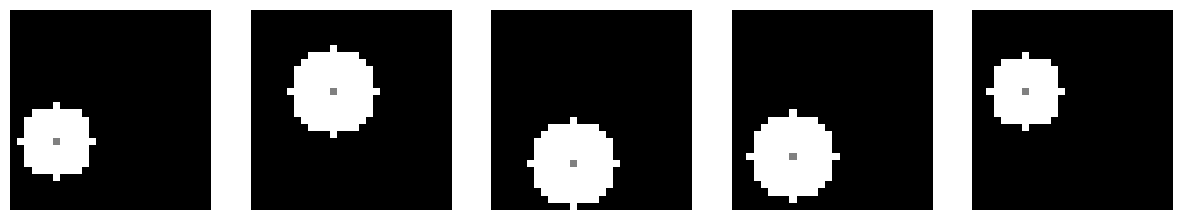

In [4]:
# Display some samples
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    image, (cx, cy) = train_dataset[i]
    cx = int(cx * image_size)
    cy = int(cy * image_size)
    to_show = image.squeeze().cpu().clone()
    to_show[cx, cy] = 0.5
    axes[i].imshow(to_show, cmap='gray')
    # axes[i].set_title(f"Label: {'Square' if label.item() == 0 else 'Circle'}")
    axes[i].axis('off')
plt.show()

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, 
                               kernel_size=6, padding=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, 
                               padding=1)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.fc = nn.Linear(12 * 2 * 2, 2)  # Adjust the dimensions accordingly
        self.tanh = nn.Tanh()


    def forward(self, x):
        x = self.pool(self.tanh(self.conv1(x)))
        x = self.pool(self.tanh(self.conv2(x)))
        x = x.view(x.shape[0], -1)  # Flatten the tensor
        x = self.fc(x)
        return x

model = SimpleCNN().to(device)
torch.manual_seed(31416)

print("Parameters:", sum(p.nelement() for p in model.parameters()))

Parameters: 980


In [6]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # update
        optimizer.step()
        running_loss += loss.item()
    if epoch % (num_epochs // 10) == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

print("Training complete")


Epoch [1/20], Loss: 0.05870351272635162
Epoch [3/20], Loss: 0.0012605875817826018
Epoch [5/20], Loss: 0.0006751298198651057
Epoch [7/20], Loss: 0.00045675043773371724
Epoch [9/20], Loss: 0.00034355352334387135
Epoch [11/20], Loss: 0.0002905934013688238
Epoch [13/20], Loss: 0.00024624758669233415
Epoch [15/20], Loss: 0.00022193435761437287
Epoch [17/20], Loss: 0.00018383450351393548
Epoch [19/20], Loss: 0.00016441953455796466
Training complete


In [7]:
# Evaluation loop
model.eval()
with torch.no_grad():
    all_loss = []
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        all_loss.append(loss.item())

print(f"MSE: {np.mean(all_loss):.5f}%")


MSE: 0.00017%


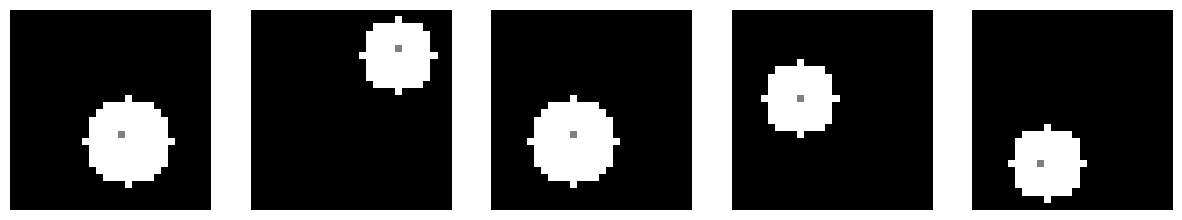

In [8]:
# Display some samples
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    idx = torch.randint(0, len(test_dataset), (1,))
    image, _ = test_dataset[idx.item()]
    cx, cy = model(image.unsqueeze(0))[0]
    cx = int(cx * image_size)
    cy = int(cy * image_size)
    to_show = image.squeeze().cpu().clone()
    
    to_show[cx, cy] = 0.5
    axes[i].imshow(to_show, cmap='gray')
    # axes[i].set_title(f"Label: {'Square' if label.item() == 0 else 'Circle'}")
    axes[i].axis('off')
plt.show()

## More points to detect: square corners

In [9]:
image_size = 28

class ShapesDataset(Dataset):
    def __init__(self, num_samples, image_size=28):
        self.num_samples = num_samples
        self.image_size = image_size
        self.data, self.labels = self.generate_data(num_samples, image_size)
        
    def generate_data(self, num_samples, image_size):
        data = []
        labels = []
        for _ in range(num_samples):
            image = np.zeros((image_size, image_size), dtype=np.float32)
            side = np.random.randint(5, image_size // 2)
            top_left_x = np.random.randint(0, image_size - side)
            top_left_y = np.random.randint(0, image_size - side)
            image[top_left_x:top_left_x+side, top_left_y:top_left_y+side] = 1.0
            data.append(image)
            points = (
                top_left_x, top_left_y, 
                top_left_x, top_left_y + side - 1,
                top_left_x  + side - 1, top_left_y,
                top_left_x  + side - 1, top_left_y + side - 1,
            )
            labels.append([p / image_size for p in points])
        return torch.tensor(data, device=device).unsqueeze(1), torch.tensor(labels, device=device)
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Create the dataset and dataloaders
train_dataset = ShapesDataset(num_samples=1000, image_size=image_size)
test_dataset = ShapesDataset(num_samples=200, image_size=image_size)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

train_dataset[0][0].shape, train_dataset[0][1].shape


(torch.Size([1, 28, 28]), torch.Size([8]))

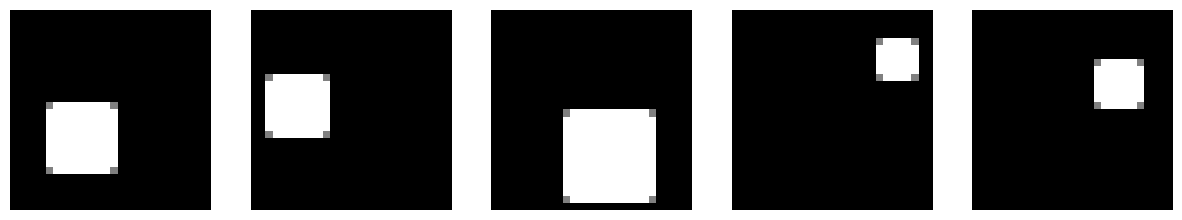

In [10]:
# Display some samples
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    image, points = train_dataset[i]
    to_show = image.squeeze().cpu().clone()
    for px, py in points.view(-1, 2):
        px = int(px * image_size)
        py = int(py * image_size)
        to_show[px, py] = 0.5
    axes[i].imshow(to_show, cmap='gray')
    # axes[i].set_title(f"Label: {'Square' if label.item() == 0 else 'Circle'}")
    axes[i].axis('off')
plt.show()

In [11]:
class SquareKPNN(nn.Module):
    def __init__(self):
        super(SquareKPNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, 
                               kernel_size=6, padding=1, device=device)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, 
                               padding=1, device=device)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.fc = nn.Linear(12 * 2 * 2, 8, device=device)  # Adjust the dimensions accordingly
        self.tanh = nn.Tanh()


    def forward(self, x):
        x = self.pool(self.tanh(self.conv1(x)))
        x = self.pool(self.tanh(self.conv2(x)))
        x = x.view(x.shape[0], -1)  # Flatten the tensor
        x = self.fc(x)
        return x

model = SquareKPNN()
torch.manual_seed(31416)

print("Parameters:", sum(p.nelement() for p in model.parameters()))

Parameters: 1274


In [12]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # update
        optimizer.step()
        running_loss += loss.item()
    if epoch % (num_epochs // 10) == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

print("Training complete")


Epoch [1/20], Loss: 0.05871426024939865
Epoch [3/20], Loss: 0.005491115861805156
Epoch [5/20], Loss: 0.003365690337959677
Epoch [7/20], Loss: 0.0023335166997276247
Epoch [9/20], Loss: 0.0018097749375738203
Epoch [11/20], Loss: 0.0014810307312291115
Epoch [13/20], Loss: 0.0012701151278452017
Epoch [15/20], Loss: 0.0011152504541678354
Epoch [17/20], Loss: 0.0010000202822266146
Epoch [19/20], Loss: 0.0009127076054573991
Training complete


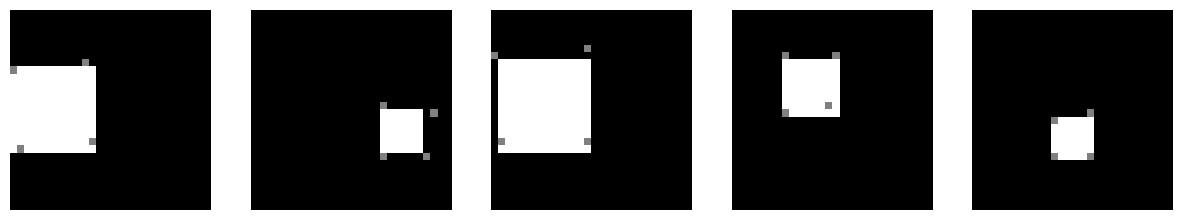

In [13]:
# Display some samples
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    idx = torch.randint(0, len(test_dataset), (1,))
    image, _ = test_dataset[idx.item()]
    points = model(image.unsqueeze(0))[0]
    to_show = image.squeeze().cpu().clone()
    for px, py in points.view(-1, 2):
        px = int(px * image_size)
        py = int(py * image_size)
        to_show[px, py] = 0.5
    axes[i].imshow(to_show, cmap='gray')
    # axes[i].set_title(f"Label: {'Square' if label.item() == 0 else 'Circle'}")
    axes[i].axis('off')
plt.show()